In [43]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas_datareader as data
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import datetime
from datetime import time
from pandas.tseries.frequencies import to_offset
import tensorflow as tf
from sklearn import metrics

In [44]:
# Choosing a period which we want to analyze for training and validating
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()

# BA boeing company, data from Yahoo finanse
stock_d = data.DataReader('BA', 'yahoo', start, end)

# week opening
def week_open(array_like):
    return array_like[0]

# week closing
def week_close(array_like):
    return array_like[-1]

# Aplied logic: that opening day is Monday, Closing day is Friday
logic = {
                        # Open - first day (Monday) opening value
                        'Open': week_open, 
                        # High - max value of the period
                         'High': 'max',
                        # Low - min value of the period
                         'Low': 'min',
                        #  Close - last day closing value (Friday)
                         'Close': week_close,
                         #  Adj Close - last day closing value (Friday)
                         'Adj Close': week_close,
                        #  Volume - sum of period Volume values
                         'Volume': 'sum'}

# Converting daily data to weekly with aplied logic
stock_w = stock_d.resample('W').apply(logic) 
stock_w.index -= to_offset('6D')


df = stock_w[['Open', 'High', 'Low',  'Close', 'Adj Close', 'Volume']] #'Close',

In [45]:
print(df)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2000-01-03   41.437500   44.875000   39.750000   44.312500   28.602894   
2000-01-10   44.312500   44.500000   42.000000   44.000000   28.401186   
2000-01-17   44.000000   48.125000   43.125000   45.687500   29.490442   
2000-01-24   45.687500   46.875000   43.625000   44.625000   28.804619   
2000-01-31   44.562500   45.187500   42.562500   44.000000   28.401186   
...                ...         ...         ...         ...         ...   
2022-05-16  127.050003  132.830002  117.080002  120.699997  120.699997   
2022-05-23  121.699997  132.229996  117.290001  132.229996  132.229996   
2022-05-30  131.029999  140.699997  127.010002  139.250000  139.250000   
2022-06-06  139.990005  142.210007  126.849998  127.000000  127.000000   
2022-06-13  123.000000  133.100006  113.019997  131.559998  131.559998   

                Volume  
Date        

In [46]:
df = df.reset_index()
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.shape)
print(train_dates.tail(15)) #Check last few dates. 

(1172,)
1157   2022-03-07
1158   2022-03-14
1159   2022-03-21
1160   2022-03-28
1161   2022-04-04
1162   2022-04-11
1163   2022-04-18
1164   2022-04-25
1165   2022-05-02
1166   2022-05-09
1167   2022-05-16
1168   2022-05-23
1169   2022-05-30
1170   2022-06-06
1171   2022-06-13
Name: Date, dtype: datetime64[ns]


In [47]:
 X_scaler = StandardScaler()
 Y_scaler = StandardScaler()
 X_data = X_scaler.fit_transform(df[['Open', 'High', 'Low', 'Adj Close', 'Close']])
 Y_data = Y_scaler.fit_transform(df[['Close']]) 

In [48]:
 def custom_ts_multi_data_prep(df, target, start, end, n_past, n_future):
     X = []
     y = []
     start = start + n_past
     if end is None:
         end = len(df) - n_future
     for i in range(start, end):
         indices = range(i-n_past, i)
         X.append(df[indices])
         indicey = range(i+1, i+1+n_future)
         y.append(target[indicey])
     return np.array(X), np.array(y) 

In [49]:
 n_past = 52
 n_future = 1
 TRAIN_SPLIT = len(df)-300
 x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, n_past, n_future)
 x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, n_past, n_future) 

In [50]:
 print ('Multiple window of past history\n')
 print(x_train[0])
 print ('\n Target horizon\n')
 print (y_train[0]) 

Multiple window of past history

[[-0.84478253 -0.82274356 -0.84850699 -0.81465741 -0.81411496]
 [-0.81414858 -0.82661798 -0.82381926 -0.81673801 -0.81743657]
 [-0.81747836 -0.78916524 -0.8114754  -0.80550242 -0.79949988]
 [-0.79949756 -0.80207998 -0.80598923 -0.81257663 -0.81079335]
 [-0.81148476 -0.81951487 -0.81764733 -0.81673801 -0.81743657]
 [-0.81881027 -0.83307535 -0.86359393 -0.84329309 -0.86128183]
 [-0.86342929 -0.87633973 -0.89102474 -0.86918158 -0.90246979]
 [-0.90272066 -0.87375678 -0.89102474 -0.85707237 -0.88320446]
 [-0.88540582 -0.89764905 -0.89651091 -0.86959904 -0.90313412]
 [-0.90338661 -0.912501   -0.93011365 -0.89339978 -0.94100047]
 [-0.94134607 -0.88408857 -0.9335425  -0.8558197  -0.88121149]
 [-0.88473986 -0.89700331 -0.90268284 -0.86918158 -0.90246979]
 [-0.90138875 -0.88408857 -0.88828166 -0.85707237 -0.88320446]
 [-0.88407391 -0.89119168 -0.89651091 -0.87126924 -0.9057914 ]
 [-0.90671639 -0.88990021 -0.90336861 -0.87335712 -0.90911301]
 [-0.90938021 -0.87052

In [51]:
 batch_size = 256
 buffer_size = 150
 train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
 train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
 val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
 val_data = val_data.batch(batch_size).repeat()

In [52]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2)) #DELETE
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(n_future))

model.compile(optimizer='adam', loss='mse', metrics='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 52, 64)            17920     
                                                                 
 dropout_2 (Dropout)         (None, 52, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [53]:

model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5) #,  mode='min'
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True,  verbose=0) #mode='min',
callbacks=[early_stopings,checkpoint] 
history = model.fit(train_data,epochs=5,steps_per_epoch=64,validation_data=val_data, validation_steps=64)

Epoch 1/5
64/64 [==============================] - 16s 215ms/step - loss: 0.0782 - mae: 0.1972 - val_loss: 2.2332 - val_mae: 1.1591
Epoch 2/5
64/64 [==============================] - 13s 210ms/step - loss: 0.0189 - mae: 0.1054 - val_loss: 12.9962 - val_mae: 2.7729
Epoch 3/5
64/64 [==============================] - 14s 223ms/step - loss: 0.0151 - mae: 0.0943 - val_loss: 111.3517 - val_mae: 7.2351
Epoch 4/5
64/64 [==============================] - 15s 230ms/step - loss: 0.0133 - mae: 0.0890 - val_loss: 14.2503 - val_mae: 2.8545
Epoch 5/5
64/64 [==============================] - 15s 238ms/step - loss: 0.0125 - mae: 0.0860 - val_loss: 15.7060 - val_mae: 2.9239


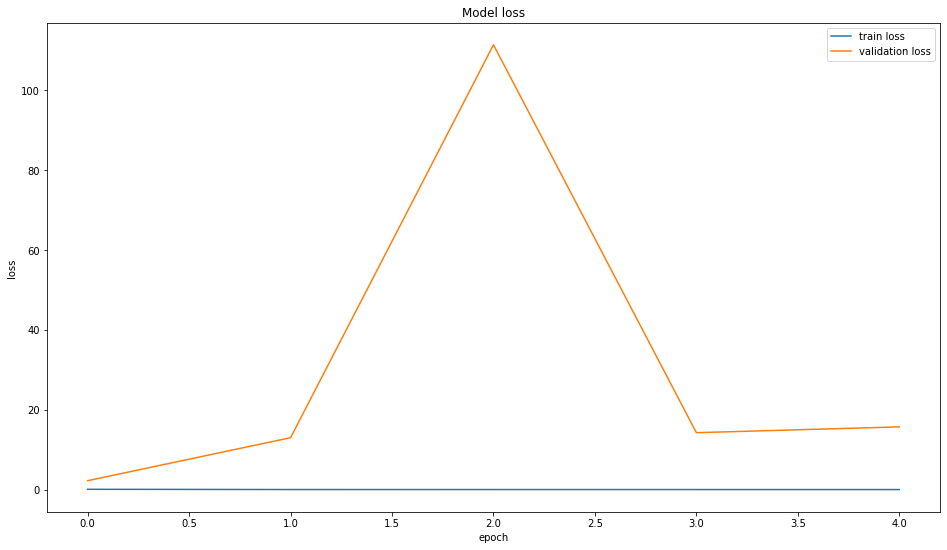

In [54]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

In [67]:
data_val = X_scaler.fit_transform(df[['Open', 'High', 'Low', 'Adj Close', 'Close']].tail(52))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse 

1/1 [==============================] - 0s 335ms/step


array([[-25.386887]], dtype=float32)

In [72]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
     def mean_absolute_percentage_error(y_true, y_pred): 
         y_true, y_pred = np.array(y_true), np.array(y_pred)
         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
     print('Evaluation metric results:-')
     print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
     print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
     print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
     print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
     print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n') 
timeseries_evaluation_metrics_func(validate['Close'], pred_Inverse[0])

NameError: name 'validate' is not defined

In [73]:
pred_Inverse[0]

array([-25.386887], dtype=float32)

In [74]:
y_true

NameError: name 'y_true' is not defined

In [ ]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['traffic_volume']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show() 